In [1]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils import get_density_map_gaussian
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
%matplotlib inline


with_direction = False

C:\Users\Stanley Wu\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


(733, 2)


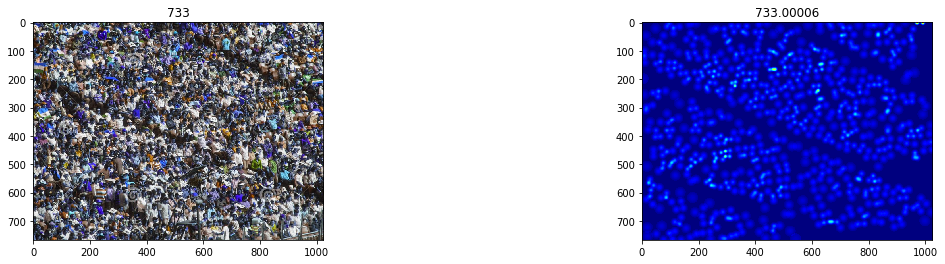

(90, 2)


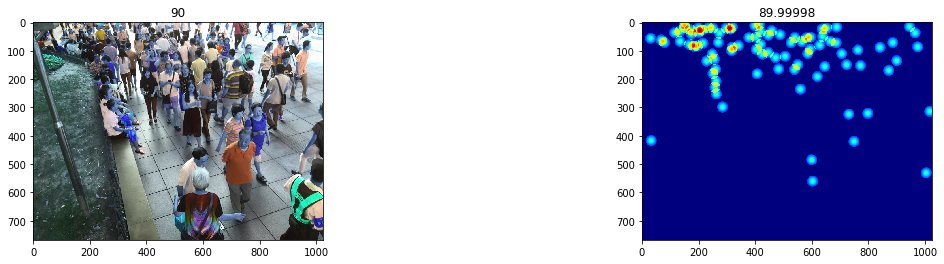

In [4]:
# Show a sample
img_paths = ['part_A/train_data/images/IMG_108.jpg',
             'part_B/train_data/images/IMG_20.jpg']
# from utils import load_img
is_adaptive = False
for img_path in img_paths:
    is_adaptive = not is_adaptive
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))

    gt = pts["image_info"][0, 0][0, 0][0]
    print(gt.shape)

    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = get_density_map_gaussian(k, gt, adaptive_mode=is_adaptive)

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(k, cmap=plt.cm.jet)
    ax1.set_title(str(np.sum(k)))
    plt.show()

In [3]:
img_ori.shape

(768, 1024, 3)

In [4]:
img_ori.shape

(768, 1024, 3)

In [5]:
k.shape

(768, 1024)

In [3]:
from data import CrowdDataSet 
import matplotlib.pyplot as plt
import numpy as np
from data import CrowdDataSet 
from data import default_train_transforms, default_test_transforms
from torchvision import transforms
from PIL import Image
from utils import get_density_map_gaussian

In [4]:
ds = CrowdDataSet('part_A/train_data/')

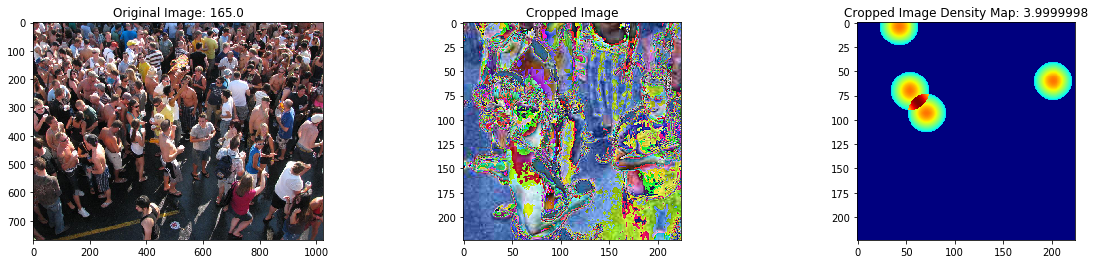

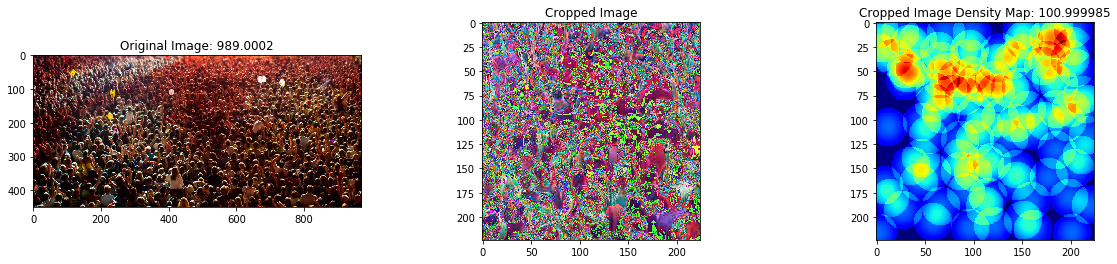

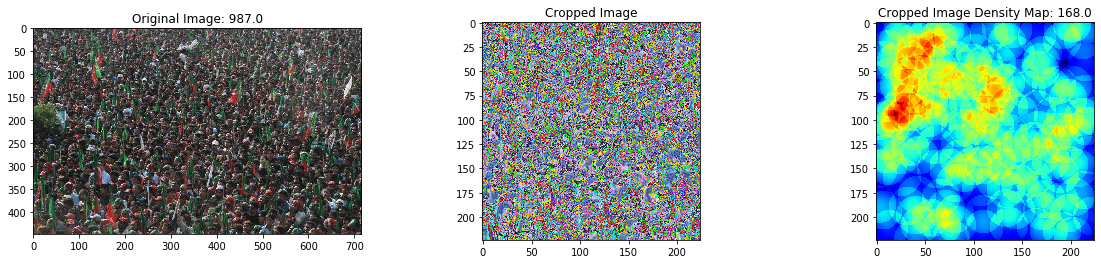

In [7]:
for i in [56, 57, 58]:
    fg, (p1, p2, p3) = plt.subplots(1, 3, figsize=(20, 4))

    x = ds[i]
    p1.imshow(x['image'])
    p1.set_title("Original Image: " + str(np.sum(x['den'])))

    loaders = {
        "train": CrowdDataSet(
            'part_A/train_data', default_train_transforms()
        ),
        "val": CrowdDataSet(
            'part_A/test_data', default_test_transforms()
        )
    }

    transformed_img = transforms.ToPILImage()(loaders['train'][i]['image']).convert('RGB')
    p2.imshow(transformed_img)
    p2.set_title("Cropped Image")

    k = np.zeros((transformed_img.width, transformed_img.height))
    k = get_density_map_gaussian(k, loaders['train'][i]['gt'], adaptive_mode=False)
    p3.imshow(k, cmap=plt.cm.jet)
    p3.set_title('Cropped Image Density Map: ' + str(np.sum(k)))

In [7]:
from models import VGG16Transfer, ResNetTransfer, InceptionV3Transfer
from trainer import train, trainInception
import torch.optim as optim
import torch.nn as nn
import torch

total = []
for samp in loaders['train']:
    k = np.zeros((224, 224))
    try:
        k = get_density_map_gaussian(k, samp['gt'], adaptive_mode=True)
    except:
        continue
    total.append(np.sum(k))
print(total)

[213.0, 54.0, 41.000004, 26.000002, 46.0, 13.000001, 138.0, 10.0, 25.0, 9.0, 48.000004, 194.0, 107.0, 5.0, 46.0, 400.00006, 116.0, 56.999992, 15.999999, 91.0, 34.999996, 120.0, 19.999998, 56.000008, 624.99994, 37.000004, 261.99997, 17.0, 109.999985, 8.0, 7.0000005, 59.0, 135.99998, 16.0, 19.999998, 182.0, 271.0, 18.0, 65.00001, 37.999996, 198.00002, 103.99999, 38.0, 92.0, 71.0, 30.000002, 12.0, 81.0, 51.0, 142.0, 130.0, 10.999999, 18.0, 33.0, 8.0, 362.0, nan, 101.0, 168.00002, 78.99999, 126.0, 44.0, 70.0, 56.999996, 14.000001, 9.999999, 120.99999, 17.0, 9.999999, 12.999999, 52.999996, 10.000001, 226.00002, 94.99999, 51.999996, 22.0, 33.0, 35.999996, 104.0, 222.0, 319.99997, 53.000004, 33.0, 20.999998, 56.0, 57.999992, 65.0, 116.000015, 9.0, 50.999996, 92.999985, 27.0, 27.999998, 171.0, 298.0, 71.0, 250.00002, 41.0, 13.0, 177.99998, 202.00002, 14.0, 81.0, 11.0, 36.999996, 21.0, 8.0, 38.0, 124.00001, 141.00002, 50.000004, 85.000015, 28.0, nan, 160.99998, 30.0, 224.99998, 0.0, 6.0, 61.999

In [7]:
import pandas as pd

print(np.eye(5)[0])
print(total[56])
pd.qcut(total, 3, labels=False, retbins=True)

[1. 0. 0. 0. 0.]


NameError: name 'total' is not defined

In [9]:
from torchvision import models
conv_layers = list(models.vgg16(pretrained=True).features.children())
conv_layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [14]:
import torch

model = torch.load('saved_models/vgg16_only_crop')
model.eval()

train_vgg16_predictions = []
train_vgg16_actual = []

for i, data in enumerate(loaders['train'], 0):
    dt = data

    image = dt['image'].to()
    gt = dt['gt']
    
    model.eval()
    predictions = model(image[None, ...].float())
    predictions = predictions.squeeze().data.cpu().numpy() 
    count = np.sum(predictions) / 100
    
    k = np.zeros((image.shape[0], image.shape[1]))
    try:
        k = get_density_map_gaussian(k, gt, adaptive_mode=True)
    except:
        continue
        
    train_vgg16_predictions.append(count)
    train_vgg16_actual.append(np.sum(k))

In [15]:
test_vgg16_predictions = []
test_vgg16_actual = []
for i, data in enumerate(loaders['val'], 0):
    dt = data

    image = dt['image'].to()
    gt = dt['gt']
    
    model.eval()
    predictions = model(image[None, ...].float())
    predictions = predictions.squeeze().data.cpu().numpy() 
    count = np.sum(predictions) / 100
    
    k = np.zeros((image.shape[0], image.shape[1]))
    try:
        k = get_density_map_gaussian(k, gt, adaptive_mode=True)
    except:
        continue
        
    test_vgg16_predictions.append(count)
    test_vgg16_actual.append(np.sum(k))

In [16]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

for i, act in enumerate(train_vgg16_actual):
    if np.isnan(act):
        train_vgg16_actual[i] = 0
for i, act in enumerate(test_vgg16_actual):
    if np.isnan(act):
        test_vgg16_actual[i] = 0

train_r2 = r2_score([float(x) for x in train_vgg16_actual], [float(x) for x in train_vgg16_predictions])
test_r2 = r2_score([float(x) for x in test_vgg16_actual], [float(x) for x in test_vgg16_predictions])
train_mse = mean_squared_error(train_vgg16_actual, train_vgg16_predictions)
test_mse = mean_squared_error(test_vgg16_actual, test_vgg16_predictions)

print("VGG16")
print('Training r2: {}'.format(train_r2))
print('Testing r2: {}'.format(test_r2))
print('Training MSE: {}'.format(train_mse))
print('Testing MSE: {}'.format(test_mse))

VGG16
Training r2: -0.8202140816556776
Testing r2: -1.2129629837957228
Training MSE: 16793.19166575508
Testing MSE: 8371.565242431945


Text(0, 0.5, 'Predictions')

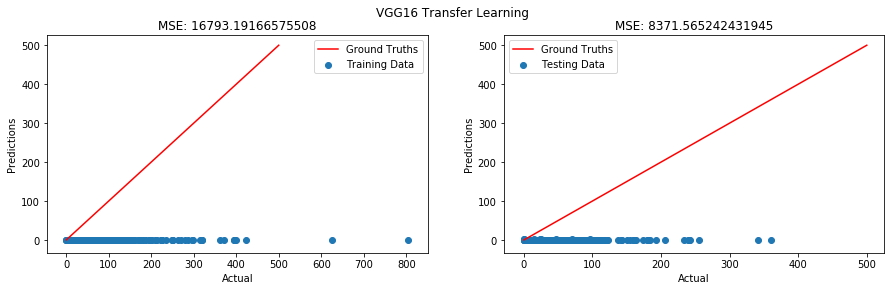

In [17]:
fg, (p1, p2) = plt.subplots(1, 2, figsize=(15, 4))

fg.suptitle('VGG16 Transfer Learning')

x = np.linspace(0,500,1000)
y = x
p1.plot(x, y, '-r', label='Ground Truths')
p1.scatter(train_vgg16_actual, train_vgg16_predictions, label='Training Data')
p1.legend()
p1.set_title('MSE: {}'.format(train_mse))
p1.set_xlabel('Actual')
p1.set_ylabel('Predictions')

p2.plot(x, y, '-r', label='Ground Truths')
p2.scatter(test_vgg16_actual, test_vgg16_predictions, label='Testing Data')
p2.legend()
p2.set_title('MSE: {}'.format(test_mse))
p2.set_xlabel('Actual')
p2.set_ylabel('Predictions')

In [ ]:
model = torch.load('saved_models/resnet18_only_crop')
model.eval()

train_resnet18_predictions = []
train_resnet18_actual = []

for i, data in enumerate(loaders['train'], 0):
    dt = data

    image = dt['image'].to()
    gt = dt['gt']
    
    model.eval()
    predictions = model(image[None, ...].float())
    predictions = predictions.squeeze().data.cpu().numpy() 
    count = np.sum(predictions) / 100
    
    k = np.zeros((image.shape[0], image.shape[1]))
    try:
        k = get_density_map_gaussian(k, gt, adaptive_mode=True)
    except:
        continue
        
    train_resnet18_predictions.append(count)
    train_resnet18_actual.append(np.sum(k))

C:\Users\Stanley Wu\Anaconda3\lib\site-packages\torch\nn\functional.py:3325: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [ ]:
test_resnet18_predictions = []
test_resnet18_actual = []
for i, data in enumerate(loaders['val'], 0):
    dt = data

    image = dt['image'].to()
    gt = dt['gt']
    
    model.eval()
    predictions = model(image[None, ...].float())
    predictions = predictions.squeeze().data.cpu().numpy() 
    count = np.sum(predictions) / 100
    
    k = np.zeros((image.shape[0], image.shape[1]))
    try:
        k = get_density_map_gaussian(k, gt, adaptive_mode=True)
    except:
        continue
        
    test_resnet18_predictions.append(count)
    test_resnet18_actual.append(np.sum(k))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

for i, act in enumerate(train_resnet18_actual):
    if np.isnan(act):
        train_resnet18_actual[i] = 0
for i, act in enumerate(test_resnet18_actual):
    if np.isnan(act):
        test_resnet18_actual[i] = 0

train_r2 = r2_score([float(x) for x in train_resnet18_actual], [float(x) for x in train_resnet18_predictions])
test_r2 = r2_score([float(x) for x in test_resnet18_actual], [float(x) for x in test_resnet18_predictions])
train_mse = mean_squared_error(train_resnet18_actual, train_resnet18_predictions)
test_mse = mean_squared_error(test_resnet18_actual, test_resnet18_predictions)

print("ResNet18")
print('Training r2: {}'.format(train_r2))
print('Testing r2: {}'.format(test_r2))
print('Training MSE: {}'.format(train_mse))
print('Testing MSE: {}'.format(test_mse))

In [ ]:
fg, (p1, p2) = plt.subplots(1, 2, figsize=(15, 4))

fg.suptitle('ResNet18 Transfer Learning')

x = np.linspace(0,500,1000)
y = x
p1.plot(x, y, '-r', label='Ground Truths')
p1.scatter(train_resnet18_actual, train_resnet18_predictions, label='Training Data')
p1.legend()
p1.set_title('MSE: {}'.format(train_mse))
p1.set_xlabel('Actual')
p1.set_ylabel('Predictions')

p2.plot(x, y, '-r', label='Ground Truths')
p2.scatter(test_resnet18_actual, test_resnet18_predictions, label='Testing Data')
p2.legend()
p2.set_title('MSE: {}'.format(test_mse))
p2.set_xlabel('Actual')
p2.set_ylabel('Predictions')

In [ ]:
vgg16loss = np.load('loss_experiments/vgg16_losses.npy')
resnet18loss = np.load('loss_experiments/resnet18_losses.npy')

plt.plot(np.arange(len(resnet18loss)), resnet18loss)